# Notebook to make Fig. 3

In [42]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd
import lal
import importlib

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D

import seaborn as sns
cp = sns.color_palette('colorblind')
cp2 = sns.color_palette('pastel')

from helper_functions import *

import sys
sys.path.append('../utils')
import reconstructwf as rwf

style.use('plotting.mplstyle')

### Load in data: strain timeseries

Load in time-domain data from the detectors

In [2]:
## TODO: finalize this with the real output dir
data_dir = '/Users/smiller/Documents/gw190521-timedomain-release/data_simonas_laptop/' 

data_dict =  np.load(data_dir+'LVC_strain_data.npy', allow_pickle=True).item()
wh_data_dict =  np.load(data_dir+'LVC_strain_data_whitened.npy', allow_pickle=True).item()
time_dict_data =  np.load(data_dir+'LVC_time_data.npy', allow_pickle=True).item()

Load in reconstructions from before/after each cutoff time

In [3]:
reconstruction_dict = np.load(data_dir+"waveform_reconstructions_L1.npy",allow_pickle=True).item()

Define timeseries

In [5]:
# 0M <-> seconds
t0_0M_dict = {}
t0_0M_geo = 1242442967.405764
dt_10M = 0.0127 # 10 M = 12.7 ms 
dt_1M = dt_10M/10.

tstart = 1242442966.9077148
tend = 1242442967.607715

ra = 6.07546535866838
dec = -0.8000357325337637

# define t_0M in each detector in seconds
for ifo in ['H1', 'L1', 'V1']: 
    
    t_delay = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix[ifo].location, ra, dec, t0_0M_geo)
    t0_0M_dict[ifo] = t0_0M_geo + t_delay
    
# Transform timeseries into into units of M
L1_LVC_strain = data_dict['L1']
L1_LVC_strain_wh = wh_data_dict['L1']
L1_LVC_strain_bp = rwf.bandpass(L1_LVC_strain, time_dict_data['L1'], 20, 500)
L1_times_M = (time_dict_data['L1'] - t0_0M_dict['L1'])/dt_1M

reconstruction_times_M = (reconstruction_dict['time samples']- t0_0M_dict['L1'])/dt_1M

### Make figure

Zoom in on a couple of times of interest ($t=-40M$ and $t=-10M$)

In [44]:
# Define some things for plotting
colors = ['blue', 'red']
x_lims_left = [-55, 70]
x_lims_center = [-100, 70]

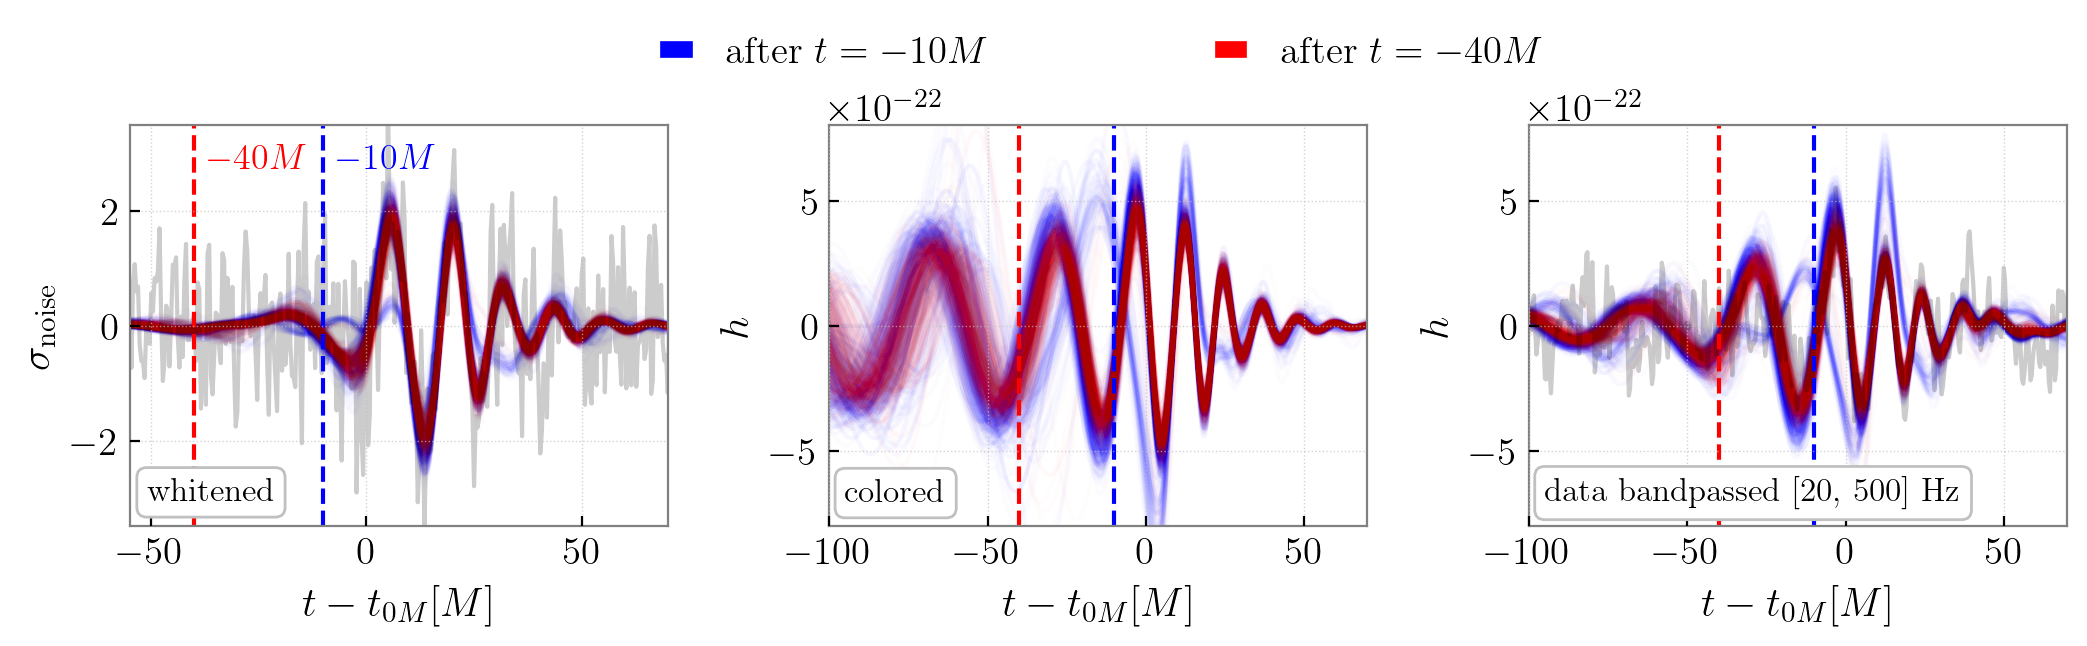

In [82]:
# Make figure
times_to_plot = ['m10M', 'm40M']
n_traces_to_plot = 500

fig, axes = plt.subplots(1, 3, figsize=(15/1.2, 25/8/1.2))

# Plot LIGO data
axes[0].plot(reconstruction_times_M, L1_LVC_strain_wh, color='k', alpha=0.2)
axes[2].plot(reconstruction_times_M, L1_LVC_strain_bp, color='k', alpha=0.2)

handles = []

for i, tc in enumerate(times_to_plot):
    
    kws=dict(color=colors[i], alpha=0.01, zorder=0)

    # downsample indices to plot 
    idxs_to_plot = np.random.choice(reconstructions_wh.shape[0], size=n_traces_to_plot)
    
    # whitened reconstructions
    reconstructions_wh = np.asarray(reconstruction_dict[f'rd {tc}']['wh'])
    axes[0].plot(reconstruction_times_M, np.transpose(reconstructions_wh[idxs_to_plot,:]), **kws)

    # unwhitened reconstructions
    reconstructions_h = np.asarray(reconstruction_dict[f'rd {tc}']['h'])
    axes[1].plot(reconstruction_times_M, np.transpose(reconstructions_h[idxs_to_plot,]), **kws)
    
    # bandpassed reconstructions
    reconstructions_bp = np.asarray(reconstruction_dict[f'rd {tc}']['bp'])
    axes[2].plot(reconstruction_times_M, np.transpose(reconstructions_bp[idxs_to_plot,]), **kws)
    
    lbl = tc.replace('m', '-') if tc[0]=='m' else tc
    handles.append(Line2D([], [], color=colors[i],label=f'after $t = {lbl}$'))
    
    # add horitonzal lines for the cutoff times
    for ax in axes:
        tc_int = -1.0*int(tc[1:-1])
        ax.axvline(tc_int, color=colors[i], ls='--')
    
    axes[0].text(tc_int+3, 2.75, f'${lbl}$', color=colors[i], fontsize=13)
    
    
axes[0].set_xlabel(r'$t-t_{0M} [M]$', fontsize=15)
axes[0].set_ylabel(r'$\sigma_\mathrm{noise}$', fontsize=15)
axes[0].grid(color='silver', ls=':', alpha=0.7)
axes[0].set_xlim(*x_lims_left)
axes[0].set_ylim(-3.5, 3.5)

axes[1].set_xlabel(r'$t-t_{0M} [M]$', fontsize=15)
axes[1].set_ylabel(r'$h$', fontsize=15)
axes[1].grid(color='silver', ls=':', alpha=0.7)
axes[1].set_xlim(*x_lims_center)
axes[1].set_ylim(-8e-22, 8e-22)

axes[2].set_xlabel(r'$t-t_{0M} [M]$', fontsize=15)
axes[2].set_ylabel(r'$h$', fontsize=15)
axes[2].grid(color='silver', ls=':', alpha=0.7)
axes[2].set_xlim(*x_lims_center)
axes[2].set_ylim(-8e-22, 8e-22)

text_kws = {'fontsize':12, 'bbox':dict(facecolor='white', edgecolor='silver', boxstyle='round')}
axes[0].text(-51, -3.05, 'whitened', **text_kws)
axes[1].text(-95, -7e-22, 'colored', **text_kws)
axes[2].text(-95, -7e-22, 'data bandpassed [20, 500] Hz', **text_kws)

axes[1].legend(handles=handles, fontsize=14, bbox_to_anchor=(-0.35, 1.1, 1.7, .102), 
               loc='lower left', ncols=2, mode="expand", borderaxespad=0., frameon=False)
    
plt.subplots_adjust(wspace=0.3)

plt.savefig('figure_03.pdf', bbox_inches='tight')
plt.show()

### Misc related plots...

Look at high mass posterior bump in the $t=-10M$ case

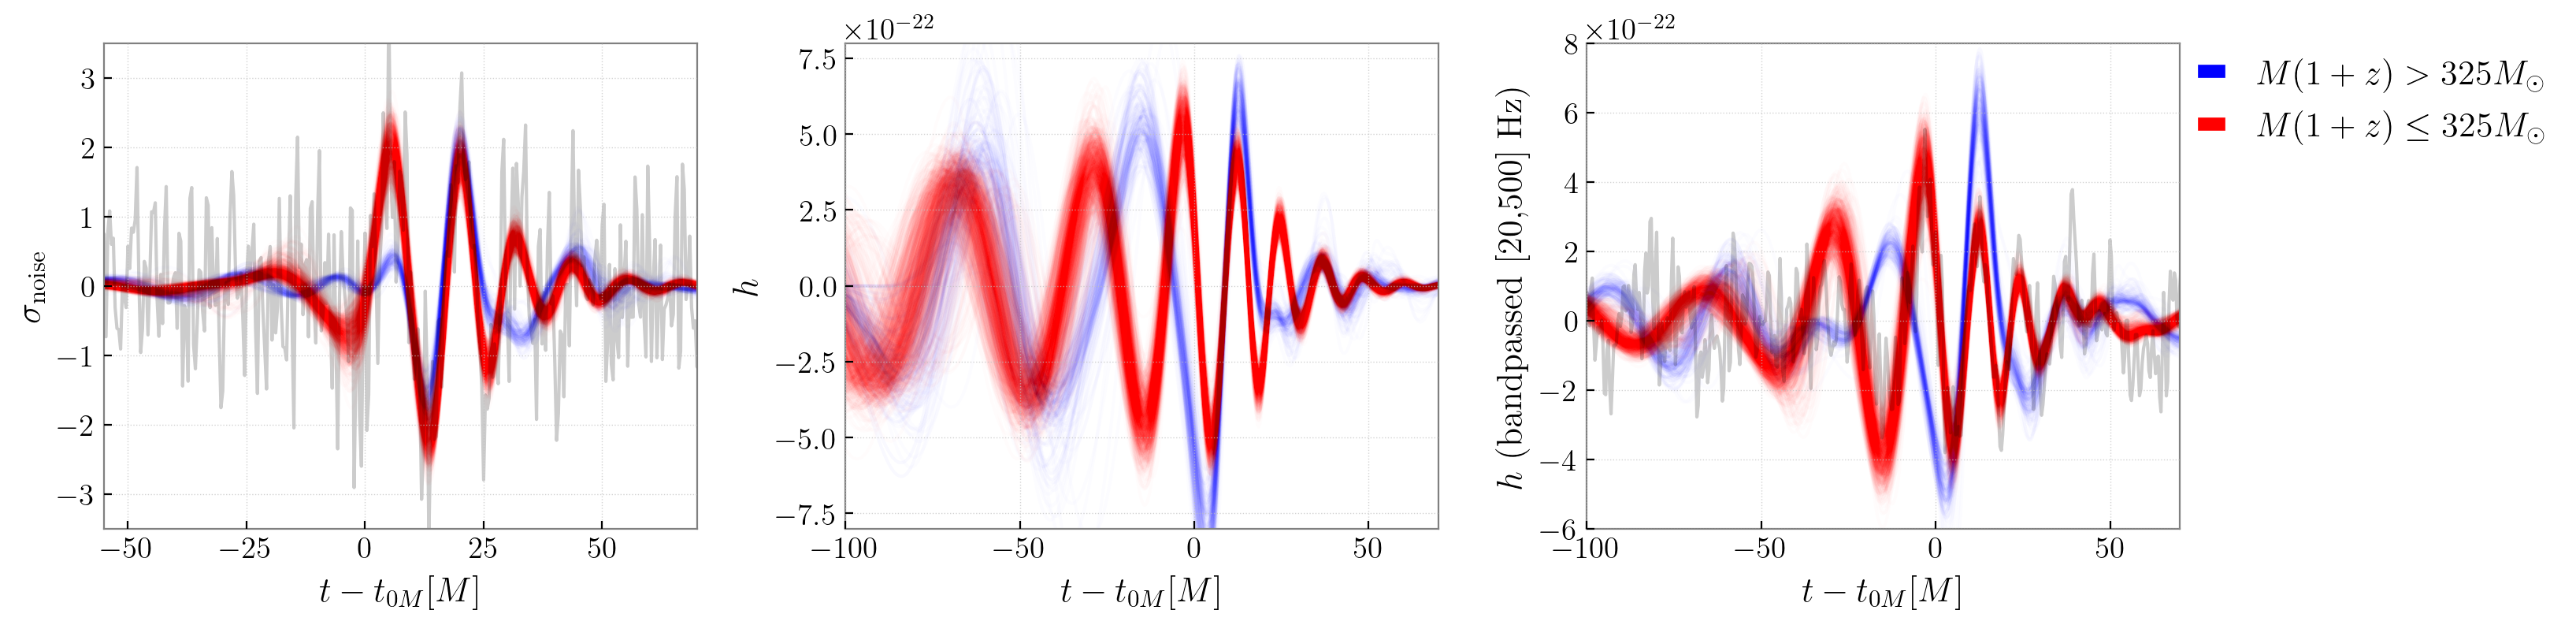

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(17, 4))

# Plot LIGO data
axes[0].plot(reconstruction_times_M, L1_LVC_strain_wh, color='k', alpha=0.2)
axes[2].plot(reconstruction_times_M, L1_LVC_strain_bp, color='k', alpha=0.2)

tc = 'm10M'
kws1 = dict(color=colors[0], alpha=0.01, zorder=0) 
kws2 = dict(color=colors[1], alpha=0.01, zorder=0)

# sort by mass
mtotals = reconstruction_dict[f'rd {tc}']['params']['mtotal']
mcutoff = 325
mask = mtotals > mcutoff

# whitened reconstructions
reconstructions_wh = np.asarray(reconstruction_dict[f'rd {tc}']['wh'])
axes[0].plot(reconstruction_times_M, np.transpose(reconstructions_wh[mask,:]), **kws1)
axes[0].plot(reconstruction_times_M, np.transpose(reconstructions_wh[~mask,:]), **kws2)

# unwhitened reconstructions
reconstructions_h = np.asarray(reconstruction_dict[f'rd {tc}']['h'])
axes[1].plot(reconstruction_times_M, np.transpose(reconstructions_h[mask,]), **kws1)
axes[1].plot(reconstruction_times_M, np.transpose(reconstructions_h[~mask,]), **kws2)

# bandpassed reconstructions
reconstructions_bp = np.asarray(reconstruction_dict[f'rd {tc}']['bp'])
axes[2].plot(reconstruction_times_M, np.transpose(reconstructions_bp[mask,]), **kws1)
axes[2].plot(reconstruction_times_M, np.transpose(reconstructions_bp[~mask,]), **kws2)    
    
axes[0].set_xlabel(r'$t-t_{0M} [M]$', fontsize=16)
axes[0].set_ylabel(r'$\sigma_\mathrm{noise}$', fontsize=16)
axes[0].grid(color='silver', ls=':', alpha=0.7)
axes[0].set_xlim(*x_lims_left)
axes[0].set_ylim(-3.5, 3.5)

axes[1].set_xlabel(r'$t-t_{0M} [M]$', fontsize=16)
axes[1].set_ylabel(r'$h$', fontsize=16)
axes[1].grid(color='silver', ls=':', alpha=0.7)
axes[1].set_xlim(*x_lims_center)
axes[1].set_ylim(-8e-22, 8e-22)

axes[2].set_xlabel(r'$t-t_{0M} [M]$', fontsize=16)
axes[2].set_ylabel(r'$h$ (bandpassed [20,500] Hz)', fontsize=16)
axes[2].grid(color='silver', ls=':', alpha=0.7)
axes[2].set_xlim(*x_lims_center)
axes[2].set_ylim(-6e-22, 8e-22)

# Make legend
handles = [Line2D([], [], color=colors[0],label=r'$M(1+z) > 325 M_\odot$'), 
           Line2D([], [], color=colors[1],label=r'$M(1+z) \leq 325 M_\odot$')]
axes[2].legend(handles=handles, fontsize=16, bbox_to_anchor=(1., 1.), borderaxespad=0., frameon=False)
    
plt.subplots_adjust(wspace=0.25)

plt.show()